# Breast Cancer Detection based on Histopathology Images

## About the Data:

- **Data Source:** https://www.kaggle.com/code/nasrulhakim86/breast-cancer-histopathology-images-classification/data
- The Breast Cancer Histopathological Image Classification (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients.
- The images are collected using different magnifying factors (40X, 100X, 200X, and 400X). 
- To date, it contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format).
- This database has been built in collaboration with the P&D Laboratory – Pathological Anatomy and Cytopathology, Parana, Brazil (http://www.prevencaoediagnose.com.br). 
- Each image filename stores information about the image itself: method of procedure biopsy, tumor class, tumor type, patient identification, and magnification factor. 
- For example, SOBBTA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB.

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#Importing all the necessary libraries for image processing
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.getcwd()

'/kaggle/working'

shutil.rmtree("./Cancer/")

In [4]:
#Loading the text file
fold_df = pd.read_csv("../input/breakhis/Folds.csv")

**Folds.csv**

1. Folds.csv contains all the information about the patient images.
2. Folds.csv consists of the magnifying factor of the image. the exact path where the image is stores.
3. So, We can extract useful information from the filename.
4. Here Folds.csv plays major role in designing the system.

In [5]:
#Defining the paths
img_path = "./BreaKHis_v1/"
classes = ["benign","malign"]

In [6]:
#Renaming the column filename to path
fold_df = fold_df.rename(columns = {"filename":"path"})
#Printing the head of the file
fold_df.head(3)

,fold,mag,grp,path
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [7]:
#One example path is printed
fold_df['path'][1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png'

**Info:**

- From the path column we can extract the exact file name using apply and split functions on the path column.
- And also the class is extracted.

In [8]:
#Extracting the filename and label from the path column
fold_df['filename'] = fold_df['path'].apply(lambda x:x.split("/")[-1])
fold_df["label"] = fold_df['path'].apply(lambda x: x.split("/")[3])

In [9]:
fold_df.head(3)

,fold,mag,grp,path,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign


**Creating New Directiory Cancer**

- The given data consists of very complex structure of folders where it stores the images.
- The structure as follows:
    - BreaKHis_v1
        - histology_slides
            - breast
                - **benign**
                    - **SOB**
                        - Type
                            - **patient_id**  
                                - 40x
                                - 100x
                                - 200x
                                - 400x
                - **malignant**
                    - **SOB**
                        - Type
                            - **patient_id**   
                                - 40x
                                - 100x
                                - 200x
                                - 400x
- To make things simple, using the exact path of the images, all the images are moved to the common folder called **Cancer.**
- Images are renamed with their class and patient_id.
                

In [10]:
#Creating new directory
##os.makedirs("../Cancer/")

ruta = "../Cancer/"

# Si existe, se elimina completamente
if os.path.exists(ruta):
    shutil.rmtree(ruta)   # elimina carpetas con contenido

# Se crea desde cero
os.makedirs(ruta)


In [11]:
#Moving all the images to one folder
for p in fold_df['path']:
    src = "../input/breakhis/BreaKHis_v1/" + p
    dest = "../Cancer/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
    shutil.copyfile(src,dest)    

In [12]:
#Checking the len
len(os.listdir("../Cancer/"))

7909

- All the images are now stores in single folder.

In [13]:
#Creating a new data frame with labels and file names stored in single folder
fold_df['file_loc'] = fold_df['label'] + "_" + fold_df['filename']
#Encoding the class to integer
fold_df['class'] = fold_df['label'].apply(lambda x: 0 if x =='benign' else 1)

In [14]:
#Printing the head to display the changed made
fold_df.head(3)

,fold,mag,grp,path,filename,label,file_loc,class
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign,benign_SOB_B_A-14-22549AB-100-001.png,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign,benign_SOB_B_A-14-22549AB-100-002.png,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign,benign_SOB_B_A-14-22549AB-100-003.png,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


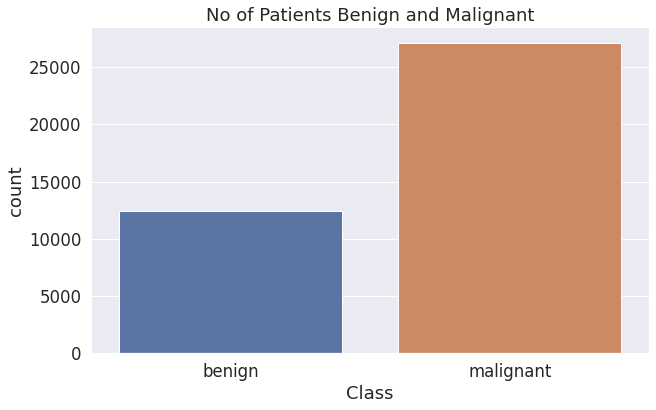

In [15]:
#Lets explore the data set
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.countplot(fold_df['label']);
plt.xlabel("Class")
plt.title("No of Patients Benign and Malignant");

- Data is Highly Imabalanced as this is the case with the real world.
- Medical datas are usually imbalanced because of their nature.

In [16]:
#Filtering the data frame to benign and malignant for visualization
benign_df = fold_df[fold_df['label'] == 'benign']
malignant_df = fold_df[fold_df['label'] == 'malignant']

# Benign Samples

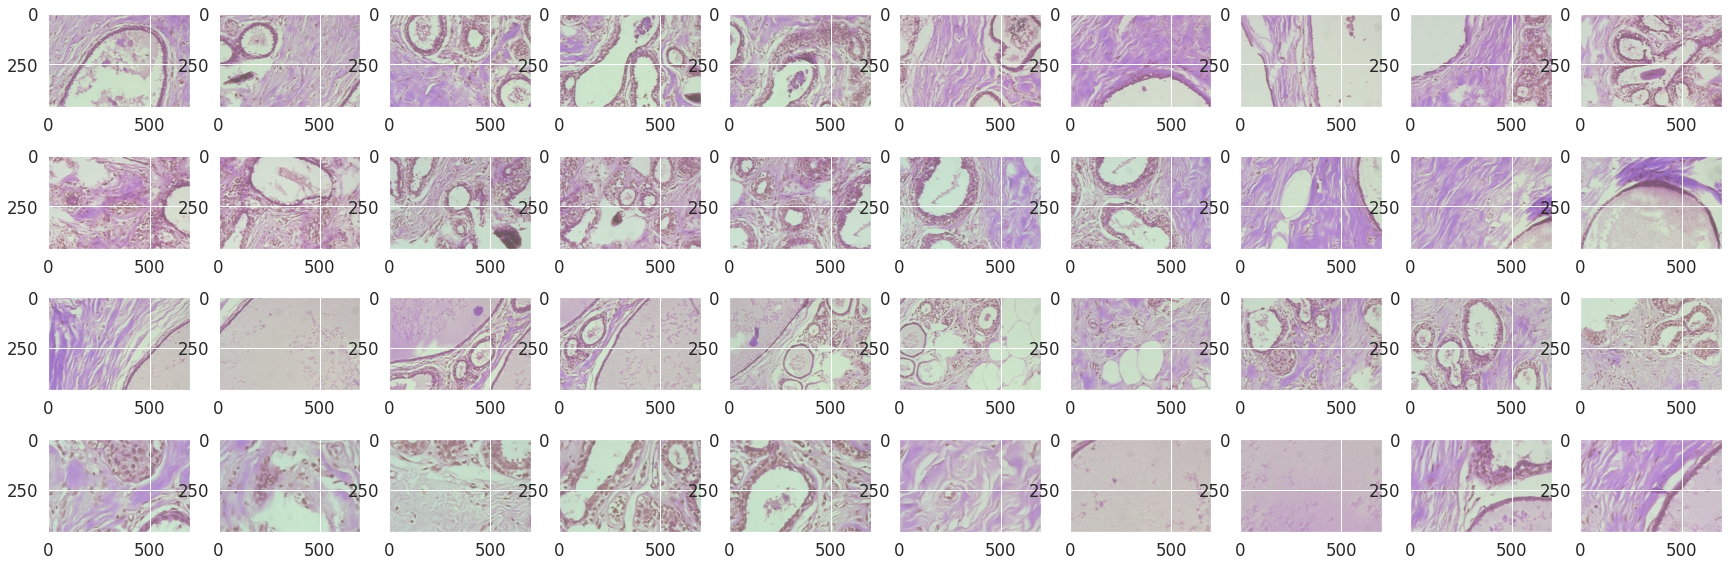

In [17]:
#Plotting the benign samples
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread("../Cancer/"+ benign_df['file_loc'][i],1)
    plt.imshow(img)

# Malignant Samples

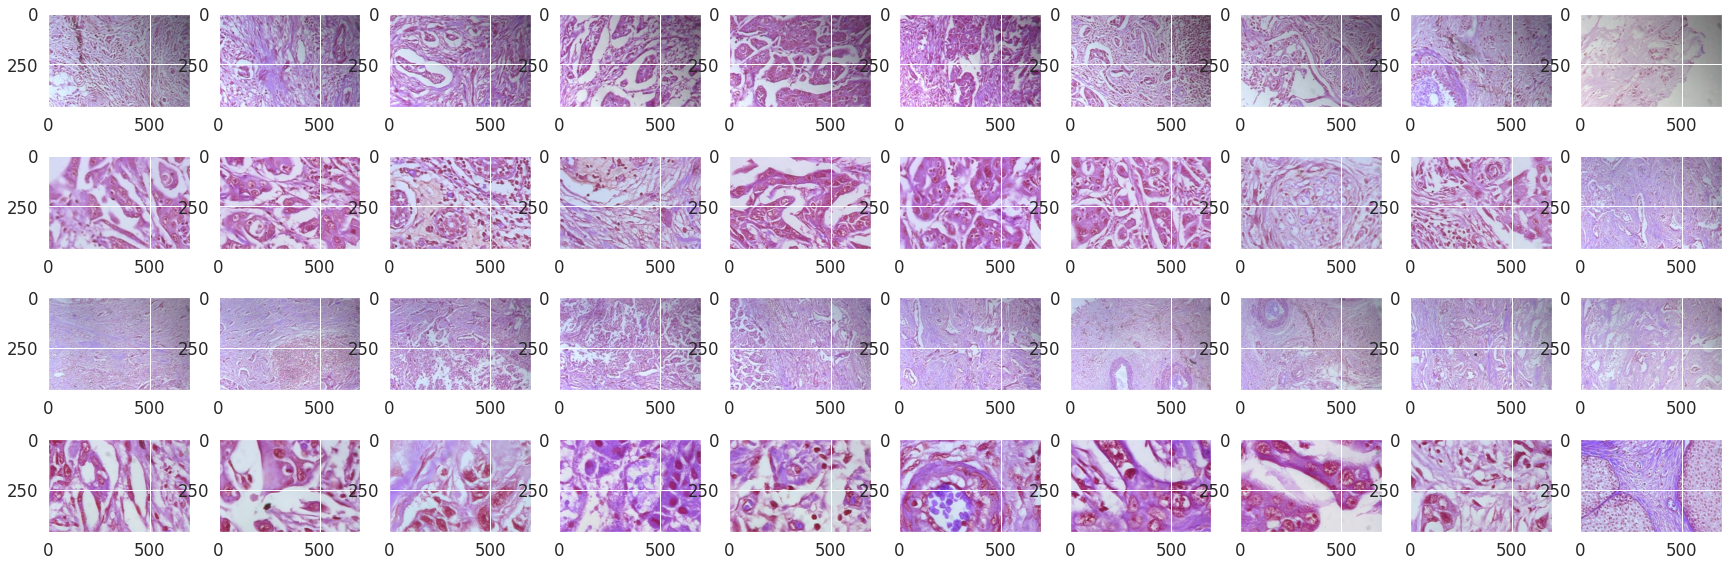

In [18]:
#Plotting the malignant samples
images = malignant_df['file_loc'].values
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread("../Cancer/"+ images[i],1)
    plt.imshow(img)

**Findings:**

- From the above images there is very little to no difference between malignant and benign samples.
- This might be because we are not the pathologists, That's the original purpose of the detection system.
- Thus it makes it easy in the absence of actual pathologists.

In [19]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
df = pd.DataFrame(os.listdir("../Cancer/"))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x:x.split("_")[0])
df['class'] = df['label'].apply(lambda x: 0 if x =='benign' else 1)
df.set_index("file_loc",inplace=True)

In [20]:
#Checking the data frame
df.head(2)

,label,class
file_loc,,
malignant_SOB_M_PC-14-12465-100-013.png,malignant,1
malignant_SOB_M_LC-14-15570C-100-002.png,malignant,1


- Using the data frame, the splitting for train, test and validation is done.
- 10% is kept aside as the test data, and 10% as validation data.
- 80% is taken as the training data.

In [21]:
#Performing the splitting
data_train_and_val, data_test = train_test_split(df, test_size = 0.1, random_state = 47)
#Traing and val
data_train, data_val = train_test_split(data_train_and_val, test_size = 0.1, random_state = 47)

In [22]:
print("Training size :", data_train.shape)
print("Validation size :", data_val.shape)
print("Testing size :", data_test.shape)

Training size : (6406, 2)
Validation size : (712, 2)
Testing size : (791, 2)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


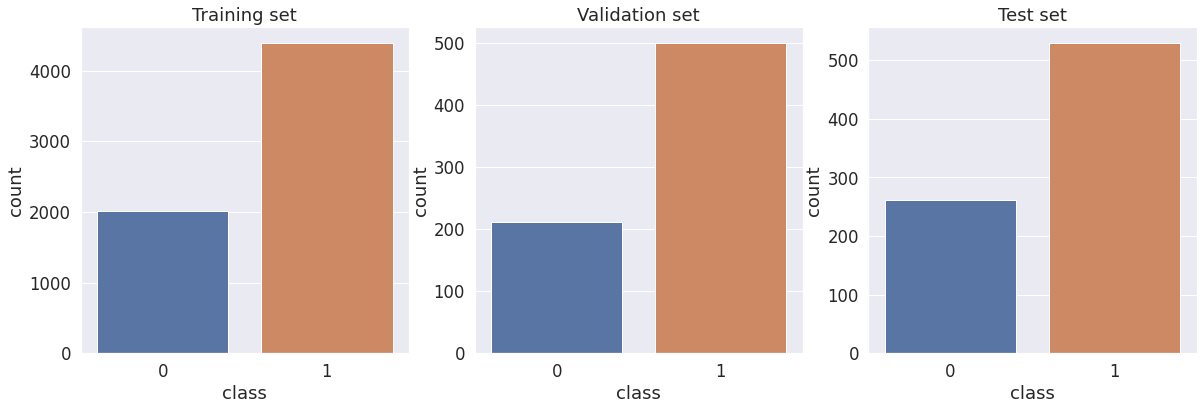

In [23]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

- Training , Validation and Testing data is pretty imbalanced as this is the case in the real world.
- Here the validation and testing set is left as it is, because it should reflects the real world scenario.
- And the training data is balanced by oversampling the minority class(Benign).

In [24]:
#Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class'] == 1]
train_has_no_cancer = data_train[data_train['class'] == 0]

In [25]:
train_has_cancer.shape

(4398, 2)

In [26]:
train_has_no_cancer.shape

(2008, 2)

In [27]:
#Upsampling the minority class by the size of majority class with replacement
train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples = len(train_has_cancer), 
                                     random_state = 47, replace = True)

In [28]:
#Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer,train_has_no_cancer_upsample])

- As expected the training data is balanced.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


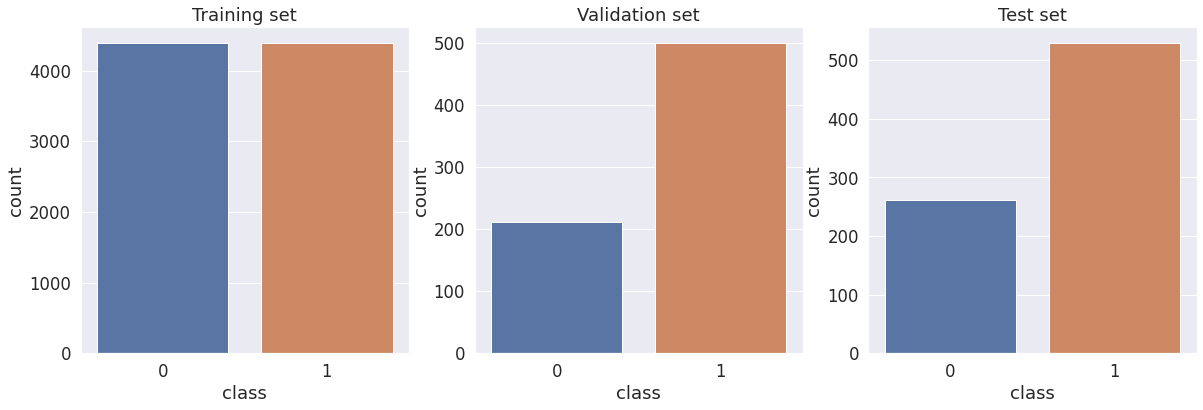

In [29]:
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

## Creating the directory structure for Training , Validation and Testing:

- Earlier all the images where stored in the single directory called Cancer.
- Now we are using Image data generator as part of our algorithm designing.
- Image data generator expects the Images to be in the following structure:
    - **Train**
        - Benign
        - Malignant
    - **Validation**
        - Benign
        - Malignant
    - **Testing**
        - Benign
        - Malignant
- Above structure is the prerequisite for the Image Data Generator to run.
        

Validamos que carpetas creadas tenemos

In [30]:
import os

print(os.listdir(".."))


['lib', 'input', 'Cancer', 'working']


auditorioa datos

In [31]:
import os

# Definimos rutas basadas en tu estructura
test_benign_path = "../Cancer_test/benign"
test_malign_path = "../Cancer_test/malignant"

# Función segura para contar archivos
def contar_archivos(ruta):
    if os.path.exists(ruta):
        conteo = len(os.listdir(ruta))
        print(f"Carpeta '{ruta}': {conteo} imágenes encontradas.")
        return conteo
    else:
        print(f"ERROR: La carpeta '{ruta}' NO existe.")
        return 0

# Ejecutamos conteo
n_benign = contar_archivos(test_benign_path)
n_malign = contar_archivos(test_malign_path)

if n_benign + n_malign == 0:
    print("ALERTA: Las carpetas están vacías o no existen. Debemos volver a separar la data.")
else:
    print("VERIFICACIÓN EXITOSA: Podemos proceder con el cálculo de métricas.")

ERROR: La carpeta '../Cancer_test/benign' NO existe.
ERROR: La carpeta '../Cancer_test/malignant' NO existe.
ALERTA: Las carpetas están vacías o no existen. Debemos volver a separar la data.


In [32]:
#Creating the directories to store images
## Pero de forma con manejo de exepciones en caso ya existan las carpetas y si existen imagenes en ellas
# os.makedirs("../Cancer_train")
# os.makedirs("../Cancer_test")
# os.makedirs("../Cancer_validation")
# os.makedirs("../Cancer_train/benign")
# os.makedirs("../Cancer_train/malignant")
# os.makedirs("../Cancer_validation/benign")
# os.makedirs("../Cancer_validation/malignant")
# os.makedirs("../Cancer_test/benign")
# os.makedirs("../Cancer_test/malignant")


import shutil

# Lista completa de carpetas a crear SIEMPRE
folders = [
    "../Cancer_train",
    "../Cancer_test",
    "../Cancer_validation",
    "../Cancer_train/benign",
    "../Cancer_train/malignant",
    "../Cancer_validation/benign",
    "../Cancer_validation/malignant",
    "../Cancer_test/benign",
    "../Cancer_test/malignant",
]

# Borrar si existe y crear siempre
for folder in folders:
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Elimina la carpeta con todo su contenido

    os.makedirs(folder)        # Vuelve a crearla limpia
    print(f"RECREADA: {folder}")

print("\n--- TODAS LAS CARPETAS FUERON BORRADAS Y RECREADAS ---")


RECREADA: ../Cancer_train
RECREADA: ../Cancer_test
RECREADA: ../Cancer_validation
RECREADA: ../Cancer_train/benign
RECREADA: ../Cancer_train/malignant
RECREADA: ../Cancer_validation/benign
RECREADA: ../Cancer_validation/malignant
RECREADA: ../Cancer_test/benign
RECREADA: ../Cancer_test/malignant

--- TODAS LAS CARPETAS FUERON BORRADAS Y RECREADAS ---


- Using the above directories and the splitted data frames data_train, data_val, data_test.
- We are moving the images to the corresponding directories based on the class of the image(Benign or Malignant).

In [33]:
#Training data
i = 1
for img in data_train.index:
    if img!=".DS_Store":
        target = df.loc[img,'class']
        if target == 1:
            label = 'malignant'
        else:          
            label = 'benign'      
        src = os.path.join("../Cancer/",img)
        dest = os.path.join("../Cancer_train/",label, "image" + str(i)+".png")
        img1 = np.array(cv2.imread(src))
        cv2.imwrite(dest,img1)
        i = i+1

In [34]:
#Validation data
for img in data_val.index:
    target = data_val.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join("../Cancer/",img)
    dest = os.path.join("../Cancer_validation/",label,img)
    shutil.copyfile(src,dest)

print("Validation data lista")

Validation data lista


In [35]:
#Testing data
for img in data_test.index:
    target = data_test.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join("../Cancer/",img)
    dest = os.path.join("../Cancer_test/",label,img)
    shutil.copyfile(src,dest)

print("Testing data lista")

Testing data lista


In [36]:
#Checking their lengths
print("#Checking their lengths")
print("Training Data:")
print(" ")
print("Benign:",len(os.listdir("../Cancer_train/benign/")))
print("Malignant::",len(os.listdir("../Cancer_train/malignant/")))
print(" ")
print("Validation Data")
print(" ")
print("Benign size:",len(os.listdir("../Cancer_validation/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_validation/malignant/")))
print(" ")
print("Testing Data:")
print(" ")
print("Benign size :",len(os.listdir("../Cancer_test/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_test/malignant/")))

#Checking their lengths
Training Data:
 
Benign: 4398
Malignant:: 4398
 
Validation Data
 
Benign size: 211
Malignant size : 501
 
Testing Data:
 
Benign size : 261
Malignant size : 530


- Training data is balanced.
- Testing and Validation data is kept as such to reflect the real scenario.

## Image Data Generator

In [37]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

- Reference:  https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.
- One of the useful methods to prevent the model from Overfitting.

- Here the **Image Data Generator** is defined with following functions:
    - Random rotation by 20 degrees.
    - Horizontal flip.
    - Vertical flip.
    - Rescale image by its pixel value.
    - Randomly Zoom image by 20%.
    - Random shear by 20%.

**Flow from Directory**
- Earlier Image folders where created as per the prerequisite.
- Here the flow_from_directory will find the number of images and their classes based on the hierarchy.
- Size of the image is set to 128x128.
- Batch size of 32 and class mode of binary(Benign or Malignant).

In [38]:
#Setting up the images for image data generator
train_generation = datagen.flow_from_directory("../Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
val_generation = datagen.flow_from_directory("../Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

Found 8796 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


# CNN Architecture 

- CNN architecture is defined using **Conv2D layers and Maxpooling layers.**
- Dropout Layers are added to randomly turn off some neurons while training to prevent from overfitting.
- Flatten layer is added at the end to form Dense Layers.
- **relu** is used as activation in all the layers and **Sigmoid** as the activation in the output layer.

In [39]:
# #Defining the base model
# cancer_model = Sequential()

# First Layer
# cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
# cancer_model.add(MaxPooling2D(pool_size = (2,2)))

# #Second Layer
# cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
# cancer_model.add(MaxPooling2D(pool_size = (2,2)))

# #Third Layer
# cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
# cancer_model.add(MaxPooling2D(pool_size = (2,2)))
# cancer_model.add(Dropout(0.4))

# #Fourth Layer
# cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
# cancer_model.add(MaxPooling2D(pool_size = (2,2)))
# cancer_model.add(Dropout(0.2))

# #Flattening the layers
# cancer_model.add(Flatten())

# #Adding the dense layer
# cancer_model.add(Dense(256, activation = 'relu'))
# cancer_model.add(Dense(128, activation = 'relu'))
# cancer_model.add(Dense(1, activation = 'sigmoid'))

# cancer_model.summary()

In [40]:
# #Setting the learning rate to reduce gradually over the training period
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   0.001,
#   decay_steps=20*50,
#   decay_rate=1,
#   staircase=False)

# def get_optimizer():
#   return tf.keras.optimizers.Adam(lr_schedule)

## **Model Compilation**

- Model is compiled by using binary crossentropy as the loss function and adam optimizer to optimize the weights.
- Early stopping is involved to monitor validation loss inorder to prevent overfitting with patience level = 5
- Modelcheckpoint is used to store the best models for every epoch.

In [41]:
# #Compiling the model
# cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
# early_stop = EarlyStopping(monitor='val_loss',patience=5)
# checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

## Model Fit 

- Model is fitted using train and validation generators generated using Image DataGenerator.
- Verbose is set to 1 to monitor accuracy and losses.
- Model is trained for 200 epochs.
- early stopping and checkpoint are used as the call backs.

#Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

## Model Results 

- The model is terminated after 49 epochs as it started overfitting.
- The model is terminated by Early stopping.
- The results are promising as the training accuracy is 93% while validation accuracy is 91.8%.

In [42]:
# #Plotting the model results

# #Getting the accuracy
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# #Getting the losses
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# #No of epochs it trained
# epochs_range = history.epoch

# #Plotting Training and Validation accuracy
# plt.figure(figsize=(16, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# #Plotting Training and Validation Loss
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

## Evaluation on Test Data 

In [43]:
## Cargarmos el ultimo modelo en caso no requiera entrenamiento


In [44]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("../Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 791 images belonging to 2 classes.


In [45]:
# pred = cancer_model.evaluate(test_gen)

- **Our CNN model is 91.5% accurate in predicting the cancer using the histopathology Images.**

In [46]:
#Let's Go ahead and test our model for few Images.

#Array to hold Input Images and their labels
test = []
labels = []

#Loading random 10 images
random_images = np.random.choice(data_test.index,10)

#For loop to read and store images
for i in random_images:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels.append(label)
    if label == 1:
        lab = "malignant"
    else:
        lab = "benign"
    #Creating path
    path = os.path.join("../Cancer_test/", lab, i)
    #reading image
    img = cv2.imread(path)
    #resizing to target shape
    img = cv2.resize(img,(128,128))
    #Making it an numpy array
    img = np.array(img)
    #Appending it to the list
    test.append(img)

#Making the list as numpy array
test = np.asarray(test)
#rescaling it by pixel value
test = test/255.   

In [47]:
# #Performing the prediction
# pred = (cancer_model.predict(test) > 0.5).astype("int32")
# #Flattening the list to form single dimensional list
# pred = pred.flatten()

In [48]:
# ## Savin the model out of kaggle
# from IPython.display import FileLink

# # Guardar el modelo en formato H5 (estándar y seguro)
# cancer_model.save('modelo_breast_cancer_final.h5')

# # Generar enlace de descarga directa
# print("Haz clic abajo para descargar tu modelo:")
# FileLink(r'modelo_breast_cancer_final.h5')

In [49]:
# #Plotting results and actual prediction
# plt.figure(figsize=(20,10))
# plt.suptitle("Prediction Vs Actual Result")
# for i in range(0,10):
#     string = "Actual:" + str(labels[i]) + ", Predicted:" + str(pred[i])
#     plt.subplot(2,5,i+1)
#     plt.imshow(test[i])
#     plt.title(string)

### Analisis de metricas del modelo

In [2]:
import os
from tensorflow.keras.models import load_model

# 1. Buscar automáticamente la ruta del archivo .h5 en los inputs
model_path = ""
print("Buscando modelo en los inputs...")

for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if file.endswith('.h5'):
            model_path = os.path.join(root, file)
            print(f"¡Encontrado! Ruta: {model_path}")
            break # Detener búsqueda al encontrarlo

# 2. Cargar el modelo en la variable original
if model_path:
    cancer_model = load_model(model_path)
    print("✅ Modelo cargado exitosamente en la variable 'cancer_model'")
    print("Ya puedes usarlo para predicciones.")
else:
    print("❌ ERROR: No se encontró ningún archivo .h5 en /kaggle/input.")
    print("Asegúrate de haber presionado 'Add Input' -> 'Your Work'.")

Buscando modelo en los inputs...
¡Encontrado! Ruta: /kaggle/input/model-base-conv2d/tensorflow2/v1-base/1/modelo_breast_cancer_final.h5
✅ Modelo cargado exitosamente en la variable 'cancer_model'
Ya puedes usarlo para predicciones.


Revisamos la estructura de nuestros archivos para obtener las metricas de forma adecuada

In [51]:
ls -lha


total 12K
drwxr-xr-x 3 root root 4.0K Nov 29 03:28 ./
drwxr-xr-x 9 root root 4.0K Nov 29 03:33 ../
drwxr-xr-x 2 root root 4.0K Nov 29 03:28 .virtual_documents/


In [4]:
ls -lha ../Cancer*


ls: cannot access '../Cancer*': No such file or directory


In [6]:
ls -lha /kaggle/input/cancer-test/


total 12K
drwxr-xr-x 6 root   root    4.0K Nov 29 18:06 ./
drwxr-xr-x 5 root   root    4.0K Nov 29 18:06 ../
drwxr-xr-x 3 nobody nogroup    0 Nov 24 04:00 breakhis/
drwxr-xr-x 3 nobody nogroup    0 Nov 29 18:06 cancer-test/
drwxr-xr-x 2 nobody nogroup    0 Nov 29 18:06 edu-resnet18-muscles/
drwxr-xr-x 3 root   root    4.0K Nov 29 18:06 model-base-conv2d/


In [7]:
ls -R /kaggle/input/cancer-test


/kaggle/input/cancer-test:
Cancer_test/

/kaggle/input/cancer-test/Cancer_test:
benign/  malignant/

/kaggle/input/cancer-test/Cancer_test/benign:
benign_SOB_B_A-14-22549AB-100-013.png  benign_SOB_B_F-14-25197-100-018.png
benign_SOB_B_A-14-22549AB-100-014.png  benign_SOB_B_F-14-25197-200-041.png
benign_SOB_B_A-14-22549AB-200-005.png  benign_SOB_B_F-14-25197-200-048.png
benign_SOB_B_A-14-22549AB-200-007.png  benign_SOB_B_F-14-25197-200-053.png
benign_SOB_B_A-14-22549AB-200-015.png  benign_SOB_B_F-14-25197-200-060.png
benign_SOB_B_A-14-22549AB-200-032.png  benign_SOB_B_F-14-25197-40-028.png
benign_SOB_B_A-14-22549AB-40-025.png   benign_SOB_B_F-14-25197-400-038.png
benign_SOB_B_A-14-22549AB-40-029.png   benign_SOB_B_F-14-25197-400-041.png
benign_SOB_B_A-14-22549AB-400-006.png  benign_SOB_B_F-14-25197-400-052.png
benign_SOB_B_A-14-22549AB-400-010.png  benign_SOB_B_F-14-25197-400-061.png
benign_SOB_B_A-14-22549AB-400-012.png  benign_SOB_B_F-14-29960AB-200-005.png
benign_SOB_B_A-14-22549AB-4

In [53]:
import os
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Rutas basadas en tu estructura confirmada
test_dir = "../Cancer_test"
categories = ["benign", "malignant"]

X_test = []
y_test = []

print("--- Iniciando carga de Test Set ---")

# Recorremos cada carpeta (benign=0, malignant=1)
for category in categories:
    path = os.path.join(test_dir, category)
    class_num = 0 if category == "benign" else 1 
    
    # Verificamos que la carpeta exista antes de entrar
    if os.path.exists(path):
        for img_name in os.listdir(path):
            try:
                # Ruta completa de la imagen
                img_path = os.path.join(path, img_name)
                
                # Leemos y redimensionamos a 128x128 (input del modelo)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (128, 128))
                
                # Normalizamos y guardamos
                X_test.append(img / 255.0)
                y_test.append(class_num)
            except Exception as e:
                pass # Ignoramos archivos corruptos si los hay

# Convertimos a numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Carga completa. Total imágenes evaluadas: {len(X_test)}")

# Ejecutamos predicción solo si hay datos
if len(X_test) > 0:
    print("Ejecutando predicciones con cancer_model...")
    
    # Obtenemos probabilidades
    y_pred_probs = cancer_model.predict(X_test, verbose=0)
    
    # Convertimos a clases (Umbral 0.5)
    y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten()
    
    # Imprimimos el reporte oficial
    print("\n" + "="*40)
    print("MÉTRICAS DEL MODELO (Test Set)")
    print("="*40)
    print(classification_report(y_test, y_pred_classes, target_names=['Benigno', 'Maligno']))
else:
    print("⚠️ ALERTA: No se encontraron imágenes en ../Cancer_test")

--- Iniciando carga de Test Set ---
Carga completa. Total imágenes evaluadas: 791
Ejecutando predicciones con cancer_model...

MÉTRICAS DEL MODELO (Test Set)
              precision    recall  f1-score   support

     Benigno       0.62      0.67      0.65       261
     Maligno       0.83      0.80      0.82       530

    accuracy                           0.76       791
   macro avg       0.73      0.74      0.73       791
weighted avg       0.76      0.76      0.76       791



Visualizacion de metricas del modelo a continuación

Text(0.5, 24.0, 'Predicho')

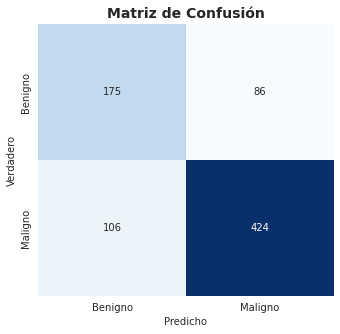

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report
import pandas as pd

# Configuración de estilo para gráficos académicos
sns.set_style("whitegrid")

# 1. MATRIZ DE CONFUSIÓN (El "Mapade errores")
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_classes)
# Heatmap azul, 'fmt=d' asegura números enteros
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.title('Matriz de Confusión', fontsize=14, fontweight='bold')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')



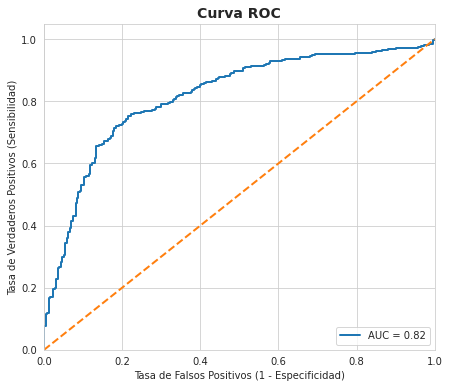

In [14]:
plt.figure(figsize=(7, 6))

# Calculamos la curva usando las probabilidades (y_pred_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")

plt.show()


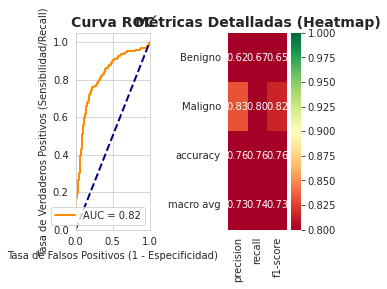

In [13]:
# 

### Metricas a nivel paciente


In [3]:
import pandas as pd
import os
import cv2
import numpy as np

# Rutas y configuración
test_dir = "../Cancer_test"
categories = ["benign", "malignant"]

data_list = [] # Lista para guardar imagen, etiqueta y nombre de archivo

print("Generando dataset para evaluación de pacientes...")

for category in categories:
    path = os.path.join(test_dir, category)
    label = 0 if category == "benign" else 1
    
    if os.path.exists(path):
        for img_name in os.listdir(path):
            try:
                # Ruta completa
                img_path = os.path.join(path, img_name)
                
                # Procesamiento idéntico al entrenamiento
                img = cv2.imread(img_path)
                img = cv2.resize(img, (128, 128))
                img = img / 255.0
                
                # Guardamos la tupla (Imagen procesada, Etiqueta Real, Nombre Archivo)
                data_list.append((img, label, img_name))
            except:
                pass

print(f"Total de imágenes procesadas: {len(data_list)}")

Generando dataset para evaluación de pacientes...
Total de imágenes procesadas: 0


Aquí convertimos las predicciones en una tabla de datos (DataFrame) y extraemos el patient_id.

In [57]:
# Separamos los datos en listas para procesar
X_val = np.array([x[0] for x in data_list])
y_true = np.array([x[1] for x in data_list])
filenames = [x[2] for x in data_list]

print("Realizando predicciones (esto puede tardar unos segundos)...")
# Predicción en lote (más rápido)
y_pred_probs = cancer_model.predict(X_val, verbose=0)
y_pred_class = (y_pred_probs > 0.5).astype("int32").flatten()

# Crear DataFrame Maestro
df_results = pd.DataFrame({
    'filename': filenames,
    'true_label': y_true,
    'pred_label': y_pred_class
})

# Lógica de extracción de ID: '...-15-190EF-...' -> tomamos el índice 2
try:
    df_results['patient_id'] = df_results['filename'].apply(lambda x: x.split('-')[2])
    print("IDs de pacientes extraídos correctamente.")
except Exception as e:
    print(f"Error extrayendo ID, revisa el formato del nombre: {e}")

print(df_results.head())

Realizando predicciones (esto puede tardar unos segundos)...
IDs de pacientes extraídos correctamente.
                                 filename  true_label  pred_label patient_id
0  benign_SOB_B_PT-14-21998AB-400-058.png           0           1    21998AB
1      benign_SOB_B_F-14-9133-400-025.png           0           1       9133
2      benign_SOB_B_F-14-25197-40-028.png           0           0      25197
3   benign_SOB_B_F-14-29960AB-200-005.png           0           1    29960AB
4   benign_SOB_B_A-14-29960CD-400-006.png           0           0    29960CD


Finalmente el calculo de metricas

In [59]:
# 1. Patient Score (PS): Exactitud por cada paciente individual
# Agrupamos por ID y calculamos la media de coincidencias (True == Pred)
patient_scores = df_results.groupby('patient_id').apply(
    lambda x: (x['true_label'] == x['pred_label']).mean()
)

# 2. Recognition Rate (RR): Promedio global de los Patient Scores
recognition_rate = patient_scores.mean()

# 3. Winner Takes All (WTA)
# Para cada paciente, la predicción final es la mayoría de votos de sus imágenes
wta_df = df_results.groupby('patient_id').agg({
    'true_label': lambda x: x.mode()[0], # La etiqueta real es constante para el paciente
    'pred_label': lambda x: x.mode()[0]  # La moda de las predicciones (Mayoría de votos)
})

# Calculamos accuracy sobre las decisiones finales por paciente
wta_accuracy = (wta_df['true_label'] == wta_df['pred_label']).mean()

print("\n" + "="*40)
print("     REPORTE DE MÉTRICAS CLÍNICAS")
print("="*40)
print(f"Total de Pacientes evaluados: {len(patient_scores)}")
print(f"Recognition Rate (RR):        {recognition_rate:.2%}")
print(f"Winner Takes All (WTA):       {wta_accuracy:.2%}")
print("="*40)

# Opcional: Ver pacientes con bajo score
print("\nPacientes con diagnósticos difíciles (PS < 50%):")
print(patient_scores[patient_scores < 0.5])


     REPORTE DE MÉTRICAS CLÍNICAS
Total de Pacientes evaluados: 81
Recognition Rate (RR):        75.11%
Winner Takes All (WTA):       80.25%

Pacientes con diagnósticos difíciles (PS < 50%):
patient_id
10147      0.285714
13413      0.357143
13418DE    0.333333
14134E     0.375000
15687B     0.400000
16184      0.300000
16601      0.250000
19854C     0.333333
22549G     0.476190
25197      0.100000
29960AB    0.000000
4364       0.000000
dtype: float64


Ahora observaremos metricas a nivel paciente para
Distribución de Puntajes de Pacientes (Histograma)

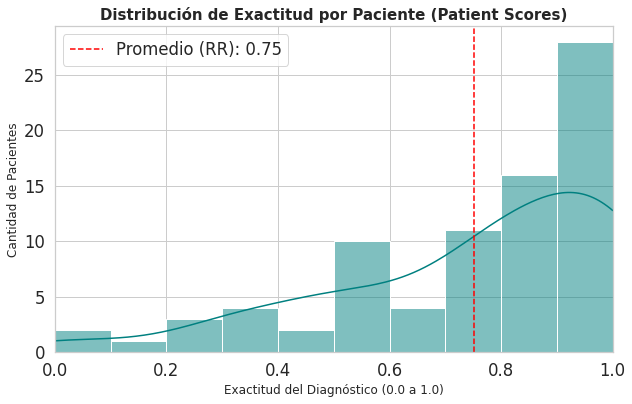

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Histograma con curva de densidad
sns.histplot(patient_scores, bins=10, kde=True, color='teal')

plt.title('Distribución de Exactitud por Paciente (Patient Scores)', fontsize=15, fontweight='bold')
plt.xlabel('Exactitud del Diagnóstico (0.0 a 1.0)', fontsize=12)
plt.ylabel('Cantidad de Pacientes', fontsize=12)
plt.xlim(0, 1.0)
plt.axvline(x=patient_scores.mean(), color='red', linestyle='--', label=f'Promedio (RR): {patient_scores.mean():.2f}')
plt.legend()

plt.show()

A continuacion veremos una comparativa entre RR vs. WTA (Graf. Barras)
Permite ver como mejora mejora el diagnóstico cuando usamos el criterio de mayoría de votos (Winner Takes All).

In [ ]:
# Datos para el gráfico
metrics_names = ['Recognition Rate (Promedio)', 'Winner Takes All (Voto Mayoría)']
metrics_values = [recognition_rate, wta_accuracy]

plt.figure(figsize=(8, 6))

# Gráfico de barras
ax = sns.barplot(x=metrics_names, y=metrics_values, palette=['#3498db', '#2ecc71'])

plt.title('Comparación: Promedio vs Voto Mayoritario', fontsize=14, fontweight='bold')
plt.ylabel('Exactitud Global', fontsize=12)
plt.ylim(0, 1.0)

# Añadir los porcentajes encima de las barras
for i, v in enumerate(metrics_values):
    ax.text(i, v + 0.02, f'{v:.2%}', ha='center', fontsize=12, fontweight='bold')

plt.show()

Ahora un analisis de casos dificiles

In [ ]:
# Filtramos y ordenamos los pacientes con score bajo (< 0.5)
# Usamos las variables que ya tienes en memoria del paso anterior
difficult_patients = patient_scores[patient_scores < 0.5].sort_values()

plt.figure(figsize=(10, 8))

# Gráfico de barras horizontales
sns.barplot(x=difficult_patients.values, y=difficult_patients.index, palette='Reds_r')

plt.title('Pacientes con Diagnóstico Crítico (< 50% Acierto)', fontsize=14, fontweight='bold')
plt.xlabel('Porcentaje de Imágenes Acertadas', fontsize=12)
plt.ylabel('ID del Paciente', fontsize=12)
plt.xlim(0, 0.6) # Limitamos el eje X para ver mejor los fallos

# Línea de referencia del 50%
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
plt.text(0.51, len(difficult_patients)-1, 'Umbral de duda (50%)', va='center')

plt.show()

1. 

Carga dedatos de prueba

In [9]:
import os
import cv2
import numpy as np

# Rutas exactas basadas en tu estructura
# test_dirs = {
#     'benign': '../Cancer_test/benign',
#     'malignant': '../Cancer_test/malignant'
# }

test_dirs = {
    'benign': '/kaggle/input/cancer-test/Cancer_test/benign',
    'malignant': '/kaggle/input/cancer-test/Cancer_test/malignant'
}

X_test = []
y_test = []

print("Iniciando carga desde carpetas de Test...")

# Iteramos: 0 para benign, 1 para malignant
for label_name, dir_path in test_dirs.items():
    label_code = 0 if label_name == 'benign' else 1
    
    # Listamos archivos en la carpeta
    if os.path.exists(dir_path):
        files = os.listdir(dir_path)
        for f in files:
            try:
                # Ruta completa
                img_path = os.path.join(dir_path, f)
                
                # Lectura y preprocesamiento (Resize a 128x128)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (128, 128))
                
                # Normalización y guardado
                X_test.append(img / 255.0)
                y_test.append(label_code)
            except Exception as e:
                pass # Ignoramos archivos corruptos si los hubiera

# Convertimos a arrays de Numpy
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Carga finalizada.")
print(f"Total imágenes: {len(X_test)}")
print(f"Distribución: {np.sum(y_test == 0)} Benignos, {np.sum(y_test == 1)} Malignos")

Iniciando carga desde carpetas de Test...
Carga finalizada.
Total imágenes: 791
Distribución: 261 Benignos, 530 Malignos


In [ ]:
Y entonces metricas del modelo


Generando predicciones...

--- REPORTE DE CLASIFICACIÓN ---
              precision    recall  f1-score   support

      Benign       0.62      0.67      0.65       261
   Malignant       0.83      0.80      0.82       530

    accuracy                           0.76       791
   macro avg       0.73      0.74      0.73       791
weighted avg       0.76      0.76      0.76       791



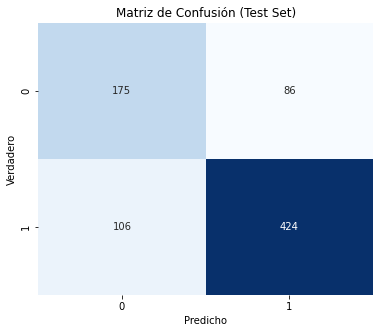

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Predicción del modelo (probabilidades)
print("Generando predicciones...")
y_pred_probs = cancer_model.predict(X_test, verbose=0)

# 2. Binarización (Umbral 0.5)
y_pred_classes = (y_pred_probs > 0.5).astype("int32").flatten()

# 3. Reporte de Métricas (Precision, Recall, F1-Score)
print("\n--- REPORTE DE CLASIFICACIÓN ---")
print(classification_report(y_test, y_pred_classes, target_names=['Benign', 'Malignant']))

# 4. Matriz de Confusión
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Test Set)')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

Calculo de metricas por paciente (PS, RR, WTA) (4)

In [11]:
# Calcular Patient Score (PS) para cada paciente
patient_metrics = df_patient.groupby('patient_id').apply(
    lambda x: (x['true_label'] == x['pred_label']).mean()
)

# 1. Recognition Rate (RR): Promedio de los PS
recognition_rate = patient_metrics.mean()

# 2. Winner Takes All (WTA)
# Agrupar por paciente y tomar la etiqueta más común predicha (moda)
wta_df = df_patient.groupby('patient_id').agg({
    'true_label': lambda x: x.mode()[0],  # Etiqueta real (debería ser la misma para todas)
    'pred_label': lambda x: x.mode()[0]   # Voto mayoritario de predicciones
})

# Calcular accuracy del WTA
wta_accuracy = (wta_df['true_label'] == wta_df['pred_label']).mean()

print(f"--- Métricas Clínicas ---")
print(f"Recognition Rate (Promedio de aciertos por paciente): {recognition_rate:.2%}")
print(f"Winner Takes All Accuracy (Diagnóstico final correcto): {wta_accuracy:.2%}")

NameError: name 'df_patient' is not defined

# Modelo 1 de CNN RESNET 18



Encontraremos la ruta para emplear el modelo

In [61]:
import os
full_path=""
def find_model_path(filename_pattern=".pth", search_path='/kaggle/input'):
    # Recorre el directorio de input buscando el archivo
    for root, dirs, files in os.walk(search_path):
        for file in files:
            if file.endswith(filename_pattern):
                full_path = os.path.join(root, file)
                print(f"✅ Archivo encontrado: {full_path}")
                return full_path
    
    print("❌ No se encontró ningún archivo .pth")
    return None

# Ejecutamos la búsqueda
model_path = find_model_path("resnet18_focal_best.pth")

✅ Archivo encontrado: /kaggle/input/edu-resnet18-muscles/resnet18_focal_best.pth


Ahora cargaremos el modelo habiendolo ya encnotrado

In [64]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear ResNet18 de forma compatible con versiones viejas y nuevas
try:
    model_cancer2 = models.resnet18(weights=None)      # para torchvision nueva
except TypeError:
    model_cancer2 = models.resnet18(pretrained=False)  # para torchvision vieja

# Adaptar la capa final a 2 clases (ajusta si tu modelo entrenado tiene otro número)
model_cancer2.fc = nn.Linear(model_cancer2.fc.in_features, 2)

model_cancer2.to(device)
model_cancer2.eval()

print("✅ Arquitectura creada. Capa final:", model_cancer2.fc)
print("Dispositivo:", device)


✅ Arquitectura creada. Capa final: Linear(in_features=512, out_features=2, bias=True)
Dispositivo: cuda


In [ ]:
buscaremos la ruta


In [65]:
import os
def find_model_path(filename_pattern=".pth", search_path='/kaggle/input'):
    # Recorre el directorio de input buscando el archivo
    for root, dirs, files in os.walk(search_path):
        for file in files:
            if file.endswith(filename_pattern):
                full_path = os.path.join(root, file)
                print(f"✅ Archivo encontrado: {full_path}")
                return full_path
    
    print("❌ No se encontró ningún archivo .pth")
    return None

# Ejecutamos la búsqueda
model_path = find_model_path("resnet18_focal_best.pth")

✅ Archivo encontrado: /kaggle/input/edu-resnet18-muscles/resnet18_focal_best.pth


In [66]:
import os

# --- EDITA AQUÍ: Pega la ruta exacta que obtuviste antes ---
SELECTED_PATH = model_path
# -----------------------------------------------------------

# Verificamos que Python pueda ver el archivo antes de intentar cargarlo
if os.path.exists(SELECTED_PATH):
    print(f"✅ Paso 2 Completado: Archivo encontrado en {SELECTED_PATH}")
else:
    print(f"❌ Error: No encuentro el archivo. Verifica la ruta.")

✅ Paso 2 Completado: Archivo encontrado en /kaggle/input/edu-resnet18-muscles/resnet18_focal_best.pth


In [67]:
# Cargamos el diccionario de pesos adaptado al dispositivo (CPU/GPU)
state_dict = torch.load(SELECTED_PATH, map_location=device)

# Inyectamos los pesos en la arquitectura
model_cancer2.load_state_dict(state_dict)

# Movemos el modelo a la GPU y lo congelamos para inferencia
model_cancer2.to(device)
model_cancer2.eval()

print("✅ Paso 3 Completado: Modelo cargado exitosamente en variable model_cancer2 Listo para usar.")

✅ Paso 3 Completado: Modelo cargado exitosamente en variable model_cancer2 Listo para usar.


## Metricas a nivel paciente de de CNN Resnet18

### Restructuracio nde datos par que modelo pueda ser evaluado adecuadamente

In [78]:
import torch
import cv2
import numpy as np
from torchvision import transforms

# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo de inferencia: {device}")

def preprocess_resnet_custom(img_path):
    """
    Lee imagen, aplica resize manteniendo aspecto, hace padding a 224x224
    y normaliza con estadísticas de ImageNet.
    """
    try:
        # 1. Leer imagen en BGR y pasar a RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 2. Calcular dimensiones para mantener el aspecto
        h, w = img.shape[:2]
        target_size = 224
        scale = target_size / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        
        # 3. Resize manteniendo proporción
        img_resized = cv2.resize(img, (new_w, new_h))
        
        # 4. Padding (Relleno con negro) para llegar a 224x224
        delta_w = target_size - new_w
        delta_h = target_size - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        
        # BORDER_CONSTANT con valor 0 (negro)
        img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, 
                                        cv2.BORDER_CONSTANT, value=[0, 0, 0])
        
        # 5. Convertir a Tensor y Normalizar (ImageNet stats)
        # Transponer de (H,W,C) -> (C,H,W) y escalar a [0,1]
        tensor = torch.from_numpy(img_padded).permute(2, 0, 1).float() / 255.0
        
        # Normalización estándar ImageNet
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = (tensor - mean) / std
        
        # Añadir dimensión de batch (1, C, H, W)
        return tensor.unsqueeze(0)
        
    except Exception as e:
        return None

Dispositivo de inferencia: cuda


Buclke de inferencia :


In [79]:
import os
import pandas as pd

# Rutas
test_dir = "../Cancer_test"
categories = ["benign", "malignant"]

# Listas para almacenar resultados
filenames_resnet = []
y_true_resnet = []
y_prob_resnet = []  # Probabilidad de ser MALIGNO (Clase 1)

# Aseguramos que el modelo esté en modo evaluación
model_cancer2.eval() 
model_cancer2.to(device)

print("--- Iniciando Inferencia con ResNet18 (PyTorch) ---")

with torch.no_grad(): # Desactivamos gradientes para ahorrar memoria y velocidad
    for category in categories:
        path = os.path.join(test_dir, category)
        label = 0 if category == "benign" else 1
        
        if os.path.exists(path):
            files = os.listdir(path)
            for i, img_name in enumerate(files):
                img_path = os.path.join(path, img_name)
                
                # Preprocesar
                img_tensor = preprocess_resnet_custom(img_path)
                
                if img_tensor is not None:
                    # Enviar a GPU
                    img_tensor = img_tensor.to(device)
                    
                    # Inferencia
                    outputs = model_cancer2(img_tensor)
                    
                    # Aplicar Softmax para obtener probabilidades
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    
                    # Extraer probabilidad de clase 1 (Maligno)
                    # Asumimos salida [prob_benigno, prob_maligno]
                    malignant_prob = probs[0][1].item()
                    
                    # Guardar datos
                    filenames_resnet.append(img_name)
                    y_true_resnet.append(label)
                    y_prob_resnet.append(malignant_prob)
                
                # Log de progreso cada 500 imágenes
                if (i+1) % 500 == 0:
                    print(f"Procesadas {i+1} imágenes de {category}...")

print(f"¡Listo! Total predicciones: {len(filenames_resnet)}")

--- Iniciando Inferencia con ResNet18 (PyTorch) ---
Procesadas 500 imágenes de malignant...
¡Listo! Total predicciones: 791


In [80]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Crear DataFrame de resultados
df_resnet = pd.DataFrame({
    'filename': filenames_resnet,
    'true_label': y_true_resnet,
    'prob_malignant': y_prob_resnet
})

# 2. Definir predicción binaria (Umbral 0.5)
df_resnet['pred_label'] = (df_resnet['prob_malignant'] > 0.5).astype(int)

# 3. Extracción de ID del paciente
# Formato esperado: 'malignant_SOB_M_PC-15-190EF-400-008.png' -> ID en posición 2 al separar por guiones
try:
    df_resnet['patient_id'] = df_resnet['filename'].apply(lambda x: x.split('-')[2])
except:
    print("⚠️ Advertencia: No se pudo extraer ID con split('-')[2]. Revisa nombres de archivo.")

# --- MÉTRICAS DEL MODELO ---
print("\n" + "="*40)
print("     RESULTADOS RESNET18 (PYTORCH)")
print("="*40)
print(classification_report(df_resnet['true_label'], df_resnet['pred_label'], target_names=['Benigno', 'Maligno']))

# --- MÉTRICAS DE PACIENTE ---
# Patient Score (PS)
patient_scores_rn = df_resnet.groupby('patient_id').apply(
    lambda x: (x['true_label'] == x['pred_label']).mean()
)

# Recognition Rate (RR)
rr_resnet = patient_scores_rn.mean()

# Winner Takes All (WTA)
wta_df_rn = df_resnet.groupby('patient_id').agg({
    'true_label': lambda x: x.mode()[0],
    'pred_label': lambda x: x.mode()[0]
})
wta_resnet = (wta_df_rn['true_label'] == wta_df_rn['pred_label']).mean()

print(f"Recognition Rate (RR):  {rr_resnet:.2%}")
print(f"Winner Takes All (WTA): {wta_resnet:.2%}")


     RESULTADOS RESNET18 (PYTORCH)
              precision    recall  f1-score   support

     Benigno       0.83      0.75      0.79       261
     Maligno       0.88      0.93      0.91       530

    accuracy                           0.87       791
   macro avg       0.86      0.84      0.85       791
weighted avg       0.87      0.87      0.87       791

Recognition Rate (RR):  88.48%
Winner Takes All (WTA): 91.36%


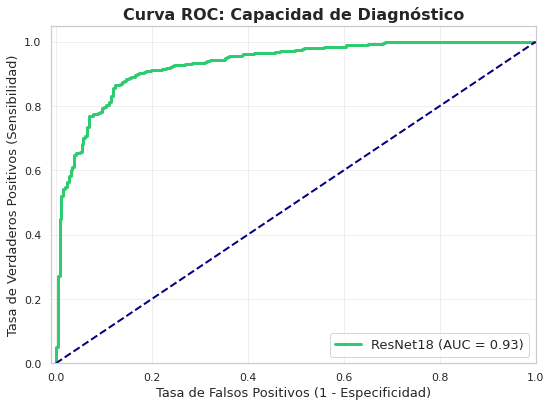

In [86]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6)) # Espacio suficiente para que la curva respire

# Cálculos
fpr, tpr, _ = roc_curve(df_resnet['true_label'], df_resnet['prob_malignant'])
roc_auc = auc(fpr, tpr)

# Plot
plt.plot(fpr, tpr, color='#2ecc71', lw=3, label=f'ResNet18 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Ajustes de Ejes
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=13)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=13)
plt.title('Curva ROC: Capacidad de Diagnóstico', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=13)
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('resnet_roc_curve_solo.png', dpi=300)
plt.show()

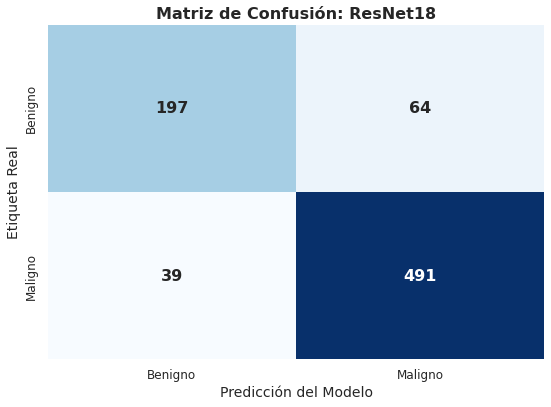

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Configuración
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6)) # Tamaño cuadrado/rectangular óptimo

# Datos
cm = confusion_matrix(df_resnet['true_label'], df_resnet['pred_label'])

# Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'],
            annot_kws={"size": 16, "weight": "bold"}) # Números más grandes

plt.title('Matriz de Confusión: ResNet18', fontsize=16, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=14)
plt.xlabel('Predicción del Modelo', fontsize=14)
plt.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('resnet_confusion_matrix_solo.png', dpi=300)
plt.show()

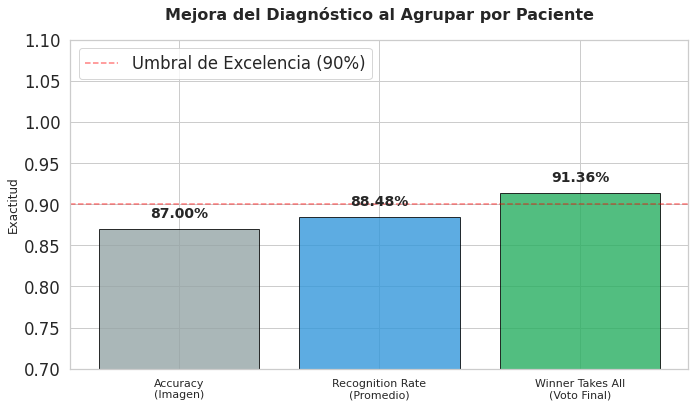

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
sns.set_style("whitegrid")

# --- MEJORA 1: Usamos \n para partir el texto en dos líneas ---
metrics = ['Accuracy\n(Imagen)', 'Recognition Rate\n(Promedio)', 'Winner Takes All\n(Voto Final)']

# Valores
values = [0.87, 0.8848, 0.9136] 
colors = ['#95a5a6', '#3498db', '#27ae60'] 

plt.figure(figsize=(10, 6))

# Gráfico de barras
bars = plt.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8)

# Línea de meta (90%)
plt.axhline(y=0.90, color='red', linestyle='--', alpha=0.5, label='Umbral de Excelencia (90%)')

plt.title('Mejora del Diagnóstico al Agrupar por Paciente', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Exactitud', fontsize=12)

# --- MEJORA 2: Damos más aire arriba (hasta 1.1) para que quepa el texto ---
plt.ylim(0.7, 1.1) 

# Poner los porcentajes encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', 
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# --- MEJORA 3: Asegurar que los ticks del eje X se lean bien ---
plt.xticks(fontsize=11, fontweight='500') # Ajustar tamaño de fuente

plt.legend(loc='upper left') # Moví la leyenda para que no estorbe a las barras
plt.tight_layout()
plt.savefig('resnet_patient_metrics_fixed.png', dpi=300)
plt.show()

Replicamos las metricas a ni vel paciente pero ahora con el modelo de CNN Resnet18 

## Descarga de estructura de carpetas

Con la finalidad de no perder el trabajo realizado y ganar tiempo en iteraciones futuras, guardamos la estructura de archivos y carpetas conseguida

In [73]:
import shutil
import os
import time

def comprimir_directorio(ruta_origen, nombre_salida):
    """
    Comprime una carpeta situada en una ruta relativa (ej: ../Cancer_test)
    y guarda el zip en el directorio actual de trabajo.
    """
    if os.path.exists(ruta_origen):
        print(f"📦 Comprimiendo '{ruta_origen}'... esto puede tomar un momento.")
        start = time.time()
        
        # root_dir: dónde buscar la carpeta base
        # base_dir: qué carpeta específica comprimir dentro de root_dir
        root = os.path.dirname(ruta_origen)
        base = os.path.basename(ruta_origen)
        
        # Creamos el zip
        shutil.make_archive(base_name=nombre_salida, format='zip', root_dir=root, base_dir=base)
        
        end = time.time()
        size_mb = os.path.getsize(f"{nombre_salida}.zip") / (1024 * 1024)
        print(f"✅ ¡Listo! '{nombre_salida}.zip' creado ({size_mb:.2f} MB) en {end - start:.1f} seg.")
        return f"{nombre_salida}.zip"
    else:
        print(f"⚠️ Error: No se encontró la ruta {ruta_origen}")
        return None

In [74]:
# Lista de carpetas críticas (Splits)
splits_folders = [
    "../Cancer_test",
    "../Cancer_validation", 
    "../Cancer_train"
]

generated_files = []

# Ejecutar compresión
for folder in splits_folders:
    # Nombre del archivo zip será el mismo de la carpeta
    name = folder.split("/")[-1] # ej: Cancer_test
    zip_file = comprimir_directorio(folder, name)
    if zip_file:
        generated_files.append(zip_file)

print("\n--- Splits comprimidos exitosamente ---")

📦 Comprimiendo '../Cancer_test'... esto puede tomar un momento.
✅ ¡Listo! 'Cancer_test.zip' creado (404.46 MB) en 15.4 seg.
📦 Comprimiendo '../Cancer_validation'... esto puede tomar un momento.
✅ ¡Listo! 'Cancer_validation.zip' creado (365.96 MB) en 13.7 seg.
📦 Comprimiendo '../Cancer_train'... esto puede tomar un momento.
✅ ¡Listo! 'Cancer_train.zip' creado (4867.50 MB) en 207.7 seg.

--- Splits comprimidos exitosamente ---


In [75]:
# Comprimir la carpeta masiva "../Cancer"
# ADVERTENCIA: Esto generará un archivo de aprox 4GB.
large_zip = comprimir_directorio("../Cancer", "Cancer_Pool_Completo")

if large_zip:
    generated_files.append(large_zip)
    print("--- Carpeta Masiva comprimida ---")

📦 Comprimiendo '../Cancer'... esto puede tomar un momento.
✅ ¡Listo! 'Cancer_Pool_Completo.zip' creado (4078.98 MB) en 170.3 seg.
--- Carpeta Masiva comprimida ---


In [77]:
from IPython.display import FileLink, display

print("⬇️ HAZ CLIC EN LOS ENLACES PARA DESCARGAR A TU PC ⬇️")
print("-" * 50)

for file in generated_files:
    print(f"Archivo: {file}")
    display(FileLink(file))
    print("-" * 20)

⬇️ HAZ CLIC EN LOS ENLACES PARA DESCARGAR A TU PC ⬇️
--------------------------------------------------
Archivo: Cancer_test.zip


/kaggle/working/Cancer_test.zip

--------------------
Archivo: Cancer_validation.zip


/kaggle/working/Cancer_validation.zip

--------------------
Archivo: Cancer_train.zip


/kaggle/working/Cancer_train.zip

--------------------
Archivo: Cancer_Pool_Completo.zip


/kaggle/working/Cancer_Pool_Completo.zip

--------------------
